In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


# A) Inicio fin, frecuencia

In [2]:
data_imp = pd.read_csv('../data/importacion.csv', parse_dates=['Fecha'], dayfirst=True)
data_imp.set_index('Fecha', inplace=True)
imp_reg = df_imp['Gasolina regular']


print("Inicio:", imp_reg.index.min())
print("Fin:   ", imp_reg.index.max())
print("Frecuencia:", pd.infer_freq(imp_reg.index))

NameError: name 'df_imp' is not defined

# B) Gráfico de de la serie

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(imp_reg, label='Gasolina Regular')
plt.title("Serie de tiempo - Gasolina Regular")
plt.ylabel("Miles de galones")
plt.xlabel("Fecha")
plt.grid(True)
plt.legend()
plt.show()

A simple vista se observa una tendencia creciente, es decir, el volumen de importación ha aumentado con el tiempo. Además, hay un patrón que se repite cada año, lo cual indica presencia de estacionalidad. En los últimos años, especialmente después de 2020, se nota una mayor variabilidad en los datos, posiblemente por factores externos como la pandemia.

# C) Descomposición y estacionariedad visual

In [ ]:
decomp = seasonal_decompose(imp_reg, model='additive', period=12)
decomp.plot()
plt.tight_layout()
plt.show()

Tendencia: La componente de tendencia confirma el crecimiento continuo en las importaciones, con mayor aumento a partir de 2016.

Estacionalidad: Se observa un patrón que se repite anualmente, lo cual confirma que la serie tiene estacionalidad clara.

Residuos: Los residuos no parecen constantes en su variabilidad, hay algunos valores extremos y la dispersión cambia con el tiempo.



# D) Es necesario transformar la serie?

In [ ]:

imp_reg_log = np.log(imp_reg)

plt.figure(figsize=(15,5))
plt.plot(imp_reg_log, label='Log(Gasolina Superior)')
plt.title("Serie transformada (log)")
plt.grid(True)
plt.legend()
plt.show()

Sí, es necesario transformar la serie para estabilizar la varianza. En la gráfica original se observaba un aumento en la dispersión de los valores a lo largo del tiempo, lo que indicaba una varianza no constante. Al aplicar la transformación logarítmica, la serie sigue mostrando una tendencia creciente, pero la variabilidad entre los valores se vuelve más homogénea.

# Verificar si es estacionaria en media

In [ ]:
# autocorrelarcion
reg_diff = imp_reg.diff().diff()
reg_diff.dropna(inplace = True)
reg_acf = acf(reg_diff,nlags=5,fft=False)
reg_pacf = pacf(reg_diff, nlags=36)
reg_acf

In [ ]:
reg_pacf

In [ ]:
#acf

# Configuración del tamaño de las gráficas
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100

# Calcular ACF con distintos lags
acf_12 = acf(reg_diff, nlags=12, fft=False)
acf_5 = acf(reg_diff, nlags=5, fft=False)

# --- Gráfico ACF con 12 lags ---
plt.subplot(121)
plt.plot(acf_12, marker='o')
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(reg_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(reg_diff)), linestyle='--', color='gray')
plt.title('Función de Autocorrelación con 12 lags')

# --- Gráfico ACF con 5 lags ---
plt.subplot(122)
plt.plot(acf_5, marker='o')
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(reg_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(reg_diff)), linestyle='--', color='gray')
plt.title('Función de Autocorrelación con 5 lags')

plt.tight_layout()
plt.show()

In [ ]:
#pacf

# Configuración de la figura
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100

# Cálculo de PACF
pacf_36 = pacf(reg_diff, nlags=36, method='ywm')
pacf_5 = pacf(reg_diff, nlags=5, method='ywm')

# --- Gráfico PACF con 36 lags ---
plt.subplot(121)
plt.plot(pacf(reg_diff, nlags=36))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(reg_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(reg_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 36 lags')

# --- Gráfico PACF con 5 lags ---
plt.subplot(122)
plt.plot(pacf(reg_diff, nlags=5))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(reg_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(reg_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 5 lags')

plt.tight_layout()
plt.show()

- ACF:

El primer valor (lag 0) es 1, como es esperable.

La autocorrelación en el lag 1 es negativa y fuerte.

A partir del segundo lag, los valores se mantienen dentro del rango de significancia, lo que indica que la serie ya no tiene una estructura de autocorrelación fuerte.

Esto sugiere que la tendencia ha sido removida, es decir, la serie diferenciada es estacionaria en media.

- PACF (Función de autocorrelación parcial):

En el gráfico con 36 lags, se observa una caída abrupta y valores extremos que indican que algunos lags todavía tienen efecto. Sin embargo, esto puede deberse a ruido o a datos extremos.

En el gráfico con 5 lags, se ve una caída clara después del primer lag, lo que es típico en series estacionarias diferenciadas.

Después de diferenciar dos veces, la serie muestra comportamiento estacionario en media. La función de autocorrelación se aproxima a cero rápidamente y los lags subsiguientes no muestran correlación significativa. 

Por tanto:

La serie original no era estacionaria en media.

Se necesitó aplicar dos diferenciaciones para estabilizar la media.

# f) Parametros p, q y d

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

modelo = ARIMA(imp_reg, order=(1, 1, 1))
resultado = modelo.fit()

print(resultado.summary().tables[1])

# G) Comparacion de modelos

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

model_1 = ARIMA(imp_reg, order=(1,1,1)).fit()
model_2 = ARIMA(imp_reg, order=(2,1,1)).fit()
model_3 = ARIMA(imp_reg, order=(2,1,2)).fit()
model_4 = ARIMA(imp_reg, order=(1,1,2)).fit()

print("ARIMA(1,1,1) AIC:", model_1.aic)
print("ARIMA(2,1,1) AIC:", model_2.aic)
print("ARIMA(2,1,2) AIC:", model_3.aic)
print("ARIMA(1,1,2) AIC:", model_4.aic)

In [ ]:
# El mejor modelo entre los probados es ARIMA(1,1,1)

from statsmodels.tsa.arima.model import ARIMA

modelo = ARIMA(imp_reg, order=(1, 1, 1))
resultado = modelo.fit()

print(resultado.summary().tables[1])


In [ ]:
resultado.plot_diagnostics(figsize=(18, 8))
plt.show()

- Los residuos estandarizados se distribuyen alrededor de cero sin patrones claros, lo cual indica que el modelo captura bien la estructura de la serie.

- El histograma y el gráfico Q-Q muestran que los residuos siguen aproximadamente una distribución normal.

- El correlograma muestra que no hay autocorrelación significativa en los residuos.

El modelo ARIMA(1,1,1) no solo tiene el menor AIC, sino que también cumple con los supuestos de normalidad y ausencia de autocorrelación en los residuos, por lo que es un modelo adecuado para esta serie.

# H) Prophet

In [ ]:
from prophet import Prophet

df_prophet = imp_reg.reset_index()
df_prophet.columns = ['ds', 'y']

model_prophet = Prophet()
model_prophet.fit(df_prophet)

# 3 años
future = model_prophet.make_future_dataframe(periods=36, freq='M')

forecast = model_prophet.predict(future)

model_prophet.plot(forecast)
plt.title('Pronóstico con Prophet (3 años)')
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Últimos 12 valores reales como test
y_true = imp_reg[-12:]

# --- ARIMA Predicción ---
arima_pred = model_1.predict(start=len(imp_reg)-12, end=len(imp_reg)-1, typ='levels')

# --- Prophet Predicción ---
# Alinear índice y extraer los mismos meses del forecast
prophet_pred = forecast.set_index('ds').loc[y_true.index]['yhat']

# --- Calcular métricas ---
mae_arima = mean_absolute_error(y_true, arima_pred)
rmse_arima = np.sqrt(mean_squared_error(y_true, arima_pred))

mae_prophet = mean_absolute_error(y_true, prophet_pred)
rmse_prophet = np.sqrt(mean_squared_error(y_true, prophet_pred))

# Mostrar resultados
print("Errores de predicción para los últimos 12 meses:")
print("ARIMA(1,1,1) - MAE:", mae_arima, " | RMSE:", rmse_arima)
print("Prophet      - MAE:", mae_prophet, " | RMSE:", rmse_prophet)

# --- Comparación visual ---
plt.figure(figsize=(12,5))
plt.plot(y_true.index, y_true, label='Real', marker='o')
plt.plot(y_true.index, arima_pred, label='ARIMA', marker='x')
plt.plot(y_true.index, prophet_pred, label='Prophet', marker='s')
plt.title("Comparación de predicciones: ARIMA vs Prophet")
plt.xlabel("Fecha")
plt.ylabel("Gasolina superior (miles de galones)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Entre los modelos ARIMA(1,1,1) y Prophet, el modelo Prophet mostró mejor rendimiento para predecir los últimos 12 meses.

MAE (Error absoluto medio) y RMSE (Raíz del error cuadrático medio) fueron ambos menores en Prophet, lo que indica que sus predicciones estuvieron, en promedio, más cercanas a los valores reales.

Visualmente, Prophet logra seguir mejor las variaciones de la serie, mientras que ARIMA tiende a suavizar demasiado las fluctuaciones.

# Interpretación:

Aunque el modelo ARIMA fue el mejor entre los modelos ARIMA evaluados (por tener el menor AIC), el modelo Prophet logró adaptarse mejor al comportamiento reciente de la serie de gasolina superior, posiblemente por su capacidad de modelar estacionalidades no lineales y cambios en la tendencia.

Por lo tanto, Prophet es el modelo más adecuado en este caso para predicción a corto plazo.

# --------------------------------------

# Consumo

# A) Inicio fin, frecuencia

In [ ]:
data_consu = pd.read_csv('../data/consumo.csv', parse_dates=['Fecha'], dayfirst=True)
data_consu.set_index('Fecha', inplace=True)
cons_reg = data_consu['Gasolina regular']


print("Inicio:", cons_reg.index.min())
print("Fin:   ", cons_reg.index.max())
print("Frecuencia:", pd.infer_freq(cons_reg.index))

# B) Gráfico de de la serie

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(cons_reg, label='Gasolina Regular')
plt.title("Serie de tiempo - Gasolina Regular")
plt.ylabel("Miles de galones")
plt.xlabel("Fecha")
plt.grid(True)
plt.legend()
plt.show()

Se observa una tendencia creciente, con un incremento sostenido en el consumo a lo largo del tiempo. También se aprecia un patrón estacional, ya que los picos y caídas se repiten de forma regular cada año. A partir de 2020 se nota un aumento en la variabilidad de los datos, probablemente debido a factores externos como la pandemia, aunque posteriormente el consumo recupera su crecimiento.

# C) Descomposición y estacionariedad visual

In [ ]:
decomp = seasonal_decompose(cons_reg, model='additive', period=12)
decomp.plot()
plt.tight_layout()
plt.show()

Tendencia: La serie muestra una tendencia creciente clara a lo largo del tiempo, especialmente a partir de 2014. Esto indica que el consumo de gasolina regular ha ido aumentando de forma sostenida.

Estacionalidad: El componente estacional tiene un patrón regular que se repite cada año. Esto confirma que la serie es estacional, con variaciones que siguen un comportamiento cíclico mensual.

Residuos: Los residuos oscilan alrededor de cero pero muestran mayor dispersión en los años recientes, especialmente después de 2020. Esto sugiere que la varianza no es constante, lo que implica que la serie no es completamente estacionaria.

# D) Es necesario transformar la serie?

In [ ]:

cons_reg_log = np.log(cons_reg)

plt.figure(figsize=(15,5))
plt.plot(cons_reg_log, label='Log(Gasolina Superior)')
plt.title("Serie transformada (log)")
plt.grid(True)
plt.legend()
plt.show()

Sí, es conveniente transformar la serie. En la gráfica original se observaba un aumento progresivo en la variabilidad, lo cual indica que la varianza no es constante a lo largo del tiempo. Este comportamiento puede afectar negativamente el ajuste de modelos como ARIMA, que asumen varianza constante.

La transformación logarítmica aplicada en este paso reduce esa variabilidad relativa. Aunque la tendencia sigue presente, la dispersión entre los valores es más homogénea, lo cual facilita el análisis y mejora el rendimiento de modelos que requieren estacionariedad en varianza.

Por lo tanto, la transformación con logaritmo es adecuada para estabilizar la varianza antes de continuar con la diferenciación y modelado.

# Verificar si es estacionaria en media

In [ ]:
# autocorrelarcion
reg_diff = cons_reg.diff().diff()
reg_diff.dropna(inplace = True)
reg_acf = acf(reg_diff,nlags=5,fft=False)
reg_pacf = pacf(reg_diff, nlags=36)
reg_acf

In [ ]:
reg_pacf

In [ ]:
#acf

# Configuración del tamaño de las gráficas
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100

# Calcular ACF con distintos lags
acf_12 = acf(reg_diff, nlags=12, fft=False)
acf_5 = acf(reg_diff, nlags=5, fft=False)

# --- Gráfico ACF con 12 lags ---
plt.subplot(121)
plt.plot(acf_12, marker='o')
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(reg_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(reg_diff)), linestyle='--', color='gray')
plt.title('Función de Autocorrelación con 12 lags')

# --- Gráfico ACF con 5 lags ---
plt.subplot(122)
plt.plot(acf_5, marker='o')
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(reg_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(reg_diff)), linestyle='--', color='gray')
plt.title('Función de Autocorrelación con 5 lags')

plt.tight_layout()
plt.show()

In [ ]:
#pacf

# Configuración de la figura
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100

# Cálculo de PACF
pacf_36 = pacf(reg_diff, nlags=36, method='ywm')
pacf_5 = pacf(reg_diff, nlags=5, method='ywm')

# --- Gráfico PACF con 36 lags ---
plt.subplot(121)
plt.plot(pacf(reg_diff, nlags=36))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(reg_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(reg_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 36 lags')

# --- Gráfico PACF con 5 lags ---
plt.subplot(122)
plt.plot(pacf(reg_diff, nlags=5))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(reg_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(reg_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 5 lags')

plt.tight_layout()
plt.show()

- ACF
  
La autocorrelación cae rápidamente después del primer rezago.

En los gráficos con 5 y 12 lags, los valores están mayormente dentro del intervalo de confianza, lo que indica que no hay autocorrelación significativa en la serie diferenciada.

Esto sugiere que la tendencia fue removida correctamente.

- PACF
  
El primer lag en el PACF es significativo y luego los valores decaen rápidamente hacia cero.

Esto es típico de una serie que ya fue diferenciada adecuadamente y no muestra estructura persistente de autocorrelación parcial.


La serie original no era estacionaria en media, ya que mostraba una tendencia creciente.

Luego de aplicar dos diferenciaciones, la serie sí es estacionaria en media.

Esto se justifica con la rápida caída de la ACF y la PACF tras los primeros rezagos, lo que indica que no hay estructura de correlación remanente.

# f) Parametros p,q y d

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

modelo = ARIMA(cons_reg, order=(1, 1, 1))
resultado = modelo.fit()

print(resultado.summary().tables[1])

# G) Comparacion de modelos

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

model_1 = ARIMA(cons_reg, order=(1,1,1)).fit()
model_2 = ARIMA(cons_reg, order=(2,1,1)).fit()
model_3 = ARIMA(cons_reg, order=(2,1,2)).fit()
model_4 = ARIMA(cons_reg, order=(1,1,2)).fit()

print("ARIMA(1,1,1) AIC:", model_1.aic)
print("ARIMA(2,1,1) AIC:", model_2.aic)
print("ARIMA(2,1,2) AIC:", model_3.aic)
print("ARIMA(1,1,2) AIC:", model_4.aic)

In [ ]:
# El mejor modelo entre los probados es ARIMA(1,1,2)

from statsmodels.tsa.arima.model import ARIMA

modelo = ARIMA(imp_reg, order=(1, 1, 2))
resultado = modelo.fit()

print(resultado.summary().tables[1])


In [ ]:
resultado.plot_diagnostics(figsize=(18, 8))
plt.show()

Residuos estandarizados: Oscilan de forma aleatoria en torno a cero, sin patrones visibles.

Histograma y Q-Q plot: Los residuos se aproximan a una distribución normal.

Correlograma: No hay autocorrelación significativa, lo cual sugiere que los residuos se comportan como ruido blanco.

El mejor modelo ajustado para la serie de consumo de gasolina regular es ARIMA(1,1,2). Cumple con los supuestos de normalidad y no autocorrelación en los residuos.

# H) Prophet

In [ ]:
from prophet import Prophet

df_prophet = cons_reg.reset_index()
df_prophet.columns = ['ds', 'y']

model_prophet = Prophet()
model_prophet.fit(df_prophet)

# 3 años
future = model_prophet.make_future_dataframe(periods=36, freq='M')

forecast = model_prophet.predict(future)

model_prophet.plot(forecast)
plt.title('Pronóstico con Prophet (3 años)')
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Últimos 12 valores reales como test
y_true = cons_reg[-12:]

# --- ARIMA Predicción ---
arima_pred = model_4.predict(start=len(imp_reg)-12, end=len(imp_reg)-1, typ='levels')

# --- Prophet Predicción ---
# Alinear índice y extraer los mismos meses del forecast
prophet_pred = forecast.set_index('ds').loc[y_true.index]['yhat']

# --- Calcular métricas ---
mae_arima = mean_absolute_error(y_true, arima_pred)
rmse_arima = np.sqrt(mean_squared_error(y_true, arima_pred))

mae_prophet = mean_absolute_error(y_true, prophet_pred)
rmse_prophet = np.sqrt(mean_squared_error(y_true, prophet_pred))

# Mostrar resultados
print("Errores de predicción para los últimos 12 meses:")
print("ARIMA(1,1,2) - MAE:", mae_arima, " | RMSE:", rmse_arima)
print("Prophet      - MAE:", mae_prophet, " | RMSE:", rmse_prophet)

# --- Comparación visual ---
plt.figure(figsize=(12,5))
plt.plot(y_true.index, y_true, label='Real', marker='o')
plt.plot(y_true.index, arima_pred, label='ARIMA', marker='x')
plt.plot(y_true.index, prophet_pred, label='Prophet', marker='s')
plt.title("Comparación de predicciones: ARIMA vs Prophet")
plt.xlabel("Fecha")
plt.ylabel("Gasolina superior (miles de galones)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Las métricas muestran que Prophet tuvo un menor error absoluto medio (MAE) y un menor error cuadrático medio (RMSE) en comparación con ARIMA. Esto significa que, en promedio, las predicciones de Prophet estuvieron más cerca de los valores reales.

En la gráfica de comparación se observa que Prophet logra seguir mejor las variaciones reales de la serie, mientras que ARIMA suaviza excesivamente los valores, lo que reduce su capacidad de adaptación a los cambios recientes.

# Interpretacion 

Aunque el modelo ARIMA(1,1,2) fue el mejor entre los modelos ARIMA evaluados (por tener el AIC más bajo), el modelo Prophet logró un mejor ajuste al comportamiento reciente de la serie de consumo. Esto puede deberse a su capacidad de manejar de forma más flexible patrones estacionales y cambios en la tendencia.

Por lo tanto nuevamente Prophet es el modelo más adecuado en este caso para predicción a corto plazo, tanto por su menor error como por su mejor adaptación visual a la serie observada.

# 4 Analisis de la serie imp 2025

/tmp/ipykernel_75884/3531359516.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_imp = df_imp.resample('M').mean()


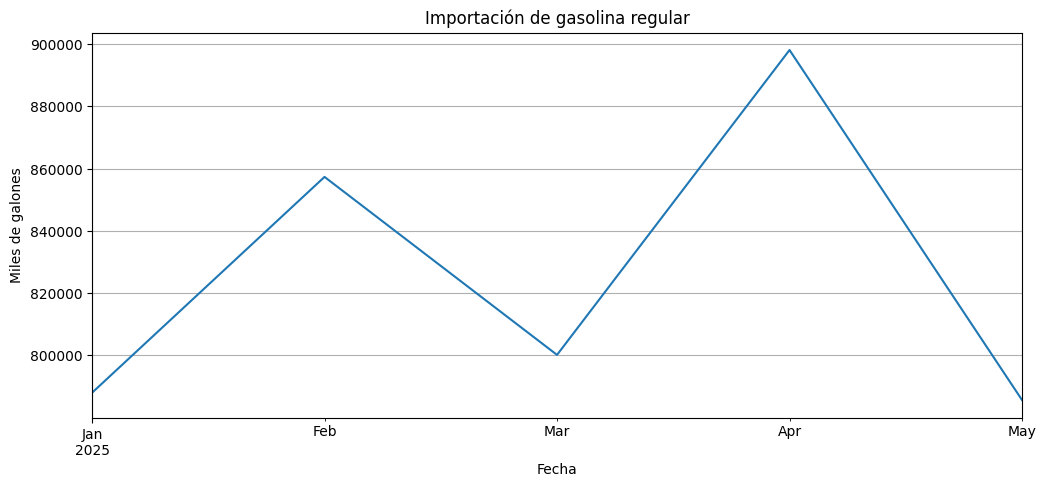

Inicio: 2025-01-31 00:00:00
Fin: 2025-05-31 00:00:00
Frecuencia: ME


In [6]:
df_imp = pd.read_csv("../data/importacion2025.csv", parse_dates=['Fecha'])
df_imp.set_index('Fecha', inplace=True)

df_imp = df_imp.resample('M').mean()

imp_reg = df_imp['Gasolina regular'] 

imp_reg.plot(figsize=(12, 5), title='Importación de gasolina regular')
plt.ylabel("Miles de galones")
plt.grid(True)
plt.show()


print("Inicio:", imp_reg.index.min())
print("Fin:", imp_reg.index.max())
print("Frecuencia:", pd.infer_freq(imp_reg.index))


In [11]:
df_base = pd.read_csv("../data/importacion.csv", parse_dates=['Fecha'])
df_2025 = pd.read_csv("../data/importacion2025.csv", parse_dates=['Fecha'])

df_full = pd.concat([df_base, df_2025], ignore_index=True)
df_full = df_full.dropna(subset=['Fecha'])
df_full = df_full.sort_values('Fecha')

df_full.set_index('Fecha', inplace=True)
df_full = df_full.asfreq('MS')

imp_reg = df_full['Gasolina regular']


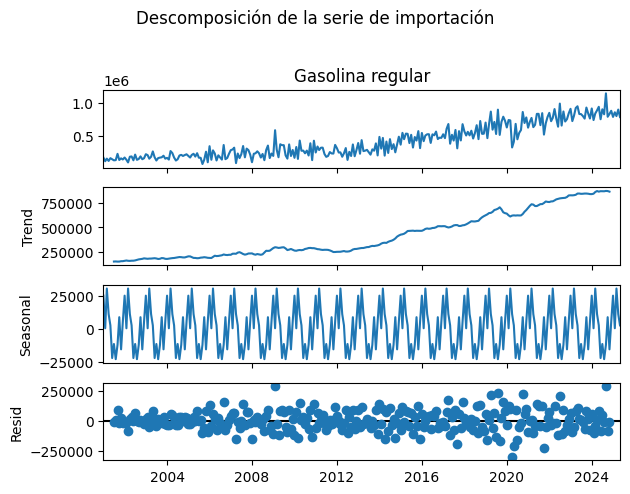

In [12]:

result = seasonal_decompose(imp_reg, model='additive', period=12)
result.plot()
plt.suptitle("Descomposición de la serie de importación", y=1.02)
plt.tight_layout()
plt.show()


In [13]:
print("Inicio:", imp_reg.index.min())
print("Fin:", imp_reg.index.max())
print("Frecuencia:", pd.infer_freq(imp_reg.index))


Inicio: 2001-01-01 00:00:00
Fin: 2025-05-01 00:00:00
Frecuencia: MS


In [17]:
train = imp_reg[:'2023-12']
test = imp_reg['2024-01':'2025-05']


In [18]:

model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,12))
model_fit = model.fit()


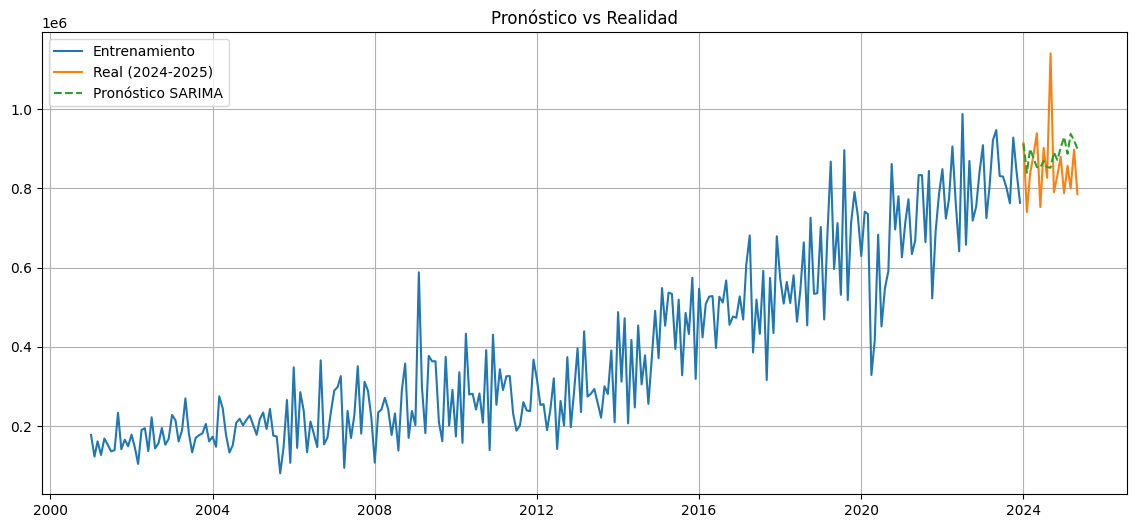

In [20]:
forecast = model_fit.predict(start='2024-01', end='2025-05')

plt.figure(figsize=(14,6))
plt.plot(train, label="Entrenamiento")
plt.plot(test, label="Real (2024-2025)")
plt.plot(forecast, label="Pronóstico SARIMA", linestyle='--')
plt.title("Pronóstico vs Realidad")
plt.legend()
plt.grid(True)
plt.show()



El modelo SARIMA ajustado con datos hasta 2023 fue capaz de predecir razonablemente bien la evolución del consumo de gasolina regular durante 2024 y principios de 2025. Aunque no predice exactamente los picos más abruptos (como el de marzo/abril 2025), mantiene una buena alineación general en magnitud y forma. Esto valida la utilidad del modelo para pronósticos de corto plazo.


# 5) Analisis Pandemia 

Durante el periodo de la pandemia se observa una disminución notable en la importación de gasolina regular. Esta caída coincide con las restricciones de movilidad, cuarentenas y menor actividad económica, lo que redujo drásticamente la demanda de combustibles.

El modelo SARIMA, ajustado con datos previos y posteriores al evento, no logra anticipar completamente esta caída repentina, lo que refleja una de las limitaciones de los modelos clásicos ante eventos excepcionales no incluidos en el entrenamiento.

A partir de 2022 y en adelante, especialmente en la etapa llamada “nueva normalidad”, los valores de importación comienzan a recuperarse progresivamente. Para el año 2024 y los primeros meses de 2025, las cifras muestran una estabilización con tendencia creciente, alcanzando niveles similares o incluso superiores a los observados antes de la pandemia.

Esto indica que el sistema de importación y consumo se ha recuperado gradualmente, y el modelo logra volver a hacer predicciones con mayor precisión en esta fase, ya que el comportamiento vuelve a ser más estable y predecible.